<a href="https://www.kaggle.com/code/pravashpurkayastha/trash-classification?scriptVersionId=113386163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
import numpy as np
import pandas as pd 
import seaborn as sb
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras.utils 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input/garbage-classification/garbage classification/Garbage classification/"))


['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


## Introduction

The project "Classification of Trash Based on Recyclability Status" aimed to develop a system that could take images of individual pieces of trash and classify them into one of five categories: glass, leather, paper, plastic, and metal. The system used a combination of computer vision and machine learning techniques to achieve this goal.

The first step in the process was to extract useful features from the images of the trash using a technique called Scale-Invariant Feature Transform (SIFT). This allowed the system to identify key points in the images that could be used to distinguish between the different types of trash.

Next, the system used a machine learning algorithm called K-means clustering to group the images into clusters based on their visual characteristics. This allowed the system to automatically identify common patterns in the images and group them accordingly.

Finally, the system used a support vector machine (SVM) to classify the images into their respective categories. The SVM used the output from the K-means clustering step to train itself, and was able to achieve an accuracy of 88% on the test data.

Overall, the project demonstrated the effectiveness of using computer vision and machine learning techniques to automatically classify trash based on its recyclability status. This could potentially be useful in a variety of settings, including waste management facilities and households, to help people sort their trash more efficiently and reduce the amount of waste that ends up in landfills.






In [25]:
trash = pd.read_csv("/kaggle/input/garbage-classification/zero-indexed-files.txt")


In [26]:

category = []
# index = []
filename = []
with open("../input/garbage-classification/zero-indexed-files.txt", "r") as file:
    for line in file:     
#      5>4?sd:dsds
        # Category of the image (label) e.g. glass
        cat = ''.join([i for i in line.split('.')[0] if not i.isdigit()])
        category.append(cat)
        
        
       #Image name e.g. glass/glass123.jpg
        filename.append(cat+"/"+line.split(' ')[0])
        
        
        #numerical value for category e.g. 0 for glass
#         index.append((line.split(' ')[1]).strip()

In [27]:
df = pd.DataFrame({
    'filename':filename,
    'category': category,
#     'index': index
})

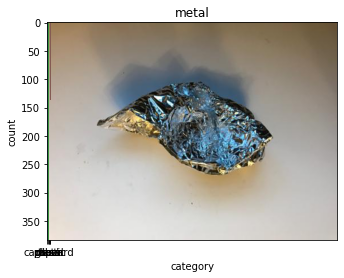

In [28]:


plt.title('Count plot')
sb.countplot(x = df['category'], data=df)
#Index 0: glass, Index 1: paper, Index 2: cardboard, Index 3: plastic, Index 4: metal, Index 5: other
#<AxesSubplot:title={'center':'Count plot'}, xlabel='category', ylabel='count'>

sample = random.choice(filename)
folder = ''.join([i for i in sample.split('.')[0] if not i.isdigit()])
    
image = load_img("../input/garbage-classification/garbage classification/Garbage classification/"+sample)
plt.title(folder.split('/')[0])
plt.imshow(image)

In [29]:


FAST_RUN = False
IMAGE_WIDTH=300
IMAGE_HEIGHT=300
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

#padding='same' returns output whose value can be computed by applying the filter to all input elements. 
#Border elements are computed using zero padding. 
#The output may be same or smaller than the input depending on the stride option.

model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.25),

    Flatten(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(6, activation='softmax') #6 because we have 6 categories
])

#Computes the crossentropy loss between the labels and predictions.
#acc metric to be evaluated by the model during training and testing
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 64)       

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#stop training when a monitored metric has stopped improving.
#patience: number of epochs with no improvement after which training will be stopped.
earlystop = EarlyStopping(patience=10)


In [31]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', #quantity to be monitored (in this case total loss)
                                            patience=2, #number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1, #0: quiet, 1: update messages
                                            factor=0.5, #factor by which the learning rate will be reduced
                                            min_lr=0.00001) #lower bound on the learning rate.

In [32]:
callbacks = [earlystop, learning_rate_reduction]

<AxesSubplot:xlabel='category', ylabel='count'>

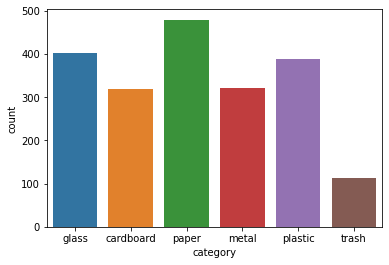

In [33]:
# df['index'] = df['category'] #.replace({0: 'glass', 1: 'paper', 2: 'cardboard', 3: 'plastic', 4: 'metal', 5: 'trash'}) 
# df.drop('index', inplace=True, axis=1)
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)#42 is the seed of randomness

#Incase a column was part of an index
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

sb.countplot(x = train_df['category'])

<AxesSubplot:xlabel='category', ylabel='count'>

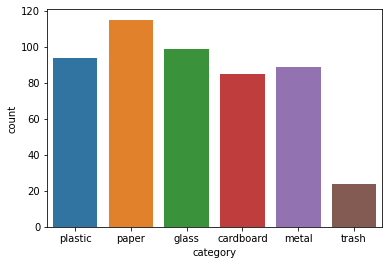

In [34]:
sb.countplot(x = validate_df['category'])

In [35]:
#.shape[0]: gives number of rows
#batch_size: number of training examples
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15, #range for random rotations
    rescale=1./255, #rescaling factor to transform every pixel value from range [0,255] -> [0,1]
    shear_range=0.1, #shear intensity, the image will be distorted along an axis
    zoom_range=0.2, #zoom in an image
    horizontal_flip=True, #randomly flip inputs horizontally
    width_shift_range=0.1, #shift horizontally(left or right)
    height_shift_range=0.1 #shift vertically(up or down)
)

#Takes the dataframe and the path to a directory and generates batches.
#The generated batches contain augmented/normalized data.
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',#the type of label arrays that are returned (in this case categorical)
    batch_size=batch_size
)
# train_generator = train_datagen.flow_from_directory(
#     "../input/garbage-classification/garbage classification/Garbage classification", 
#     target_size=(300, 300),
#     batch_size=16,
#     class_mode='categorical',
#     subset='training',
#     seed=0
# )

Found 2021 validated image filenames belonging to 6 classes.


In [37]:
validation_datagen = ImageDataGenerator(rescale=1./255) #rescaling factor to transform every pixel value from range [0,255] -> [0,1]
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 506 validated image filenames belonging to 6 classes.


In [38]:
example_df = train_df.sample(n=1).reset_index(drop=True) #n is number of images returned
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../input/garbage-classification/garbage classification/Garbage classification", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


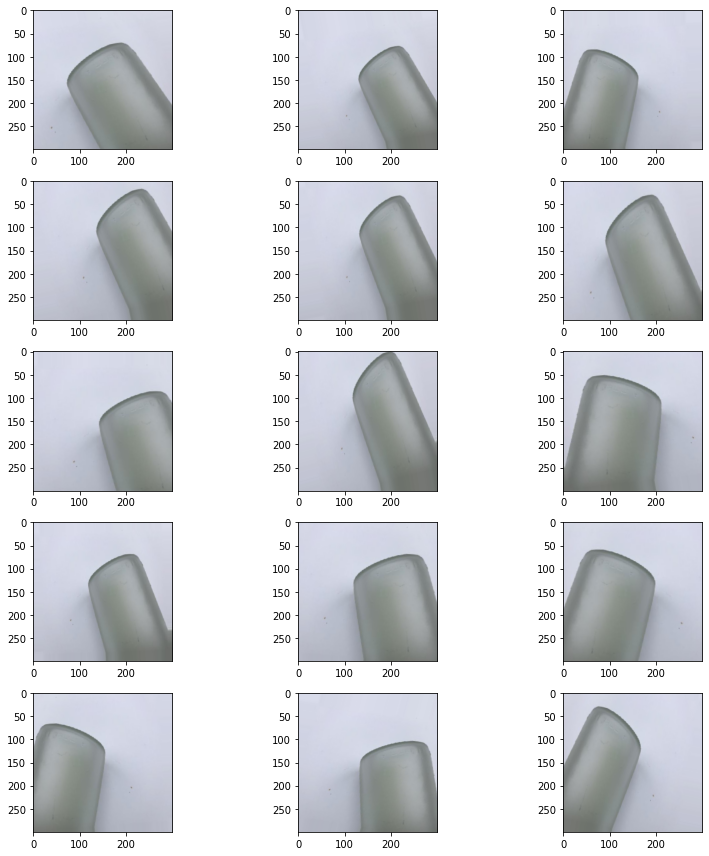

In [39]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1) #(rows,columns,index)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [40]:
model.save("model_model.h5")
model.save_weights("weight_model.h5")

In [41]:
history = model.fit_generator(
     train_generator, 
     epochs=60,
     validation_data=validation_generator,
     validation_steps=total_validate//batch_size,#specifies total number of steps taken from the generator before it is stopped at every epoch,its value is calculated as the total number of validation data points in data divided by the validation batch size.
     steps_per_epoch=total_train//batch_size,#specifies total number of steps taken from the generator as soon as one epoch is finished and next epoch has started, its value is the total number of samples in the data divided by the batch size.
     callbacks=callbacks
 )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
134/134 [==============================] - 51s 373ms/step - loss: 1.7872 - acc: 0.3689 - val_loss: 3.1032 - val_acc: 0.1960
Epoch 2/60
134/134 [==============================] - 49s 369ms/step - loss: 1.5563 - acc: 0.4332 - val_loss: 8.3524 - val_acc: 0.1838
Epoch 3/60
134/134 [==============================] - 50s 375ms/step - loss: 1.3572 - acc: 0.5120 - val_loss: 2.2048 - val_acc: 0.2747
Epoch 4/60
134/134 [==============================] - 50s 372ms/step - loss: 1.2462 - acc: 0.5364 - val_loss: 3.7772 - val_acc: 0.3071
Epoch 5/60
134/134 [==============================] - 50s 368ms/step - loss: 1.2007 - acc: 0.5484 - val_loss: 2.5995 - val_acc: 0.2687
Epoch 6/60
134/134 [==============================] - 51s 377ms/step - loss: 1.1934 - acc: 0.5563 - val_loss: 3.1775 - val_acc: 0.3212
Epoch 7/60
134/134 [==============================] - 50s 374ms/step - loss: 1.1223 - acc: 0.5872 - val_loss: 2.8099 - val_acc: 0.3475
Epoch 8/60
134/134 [==============================] - 5

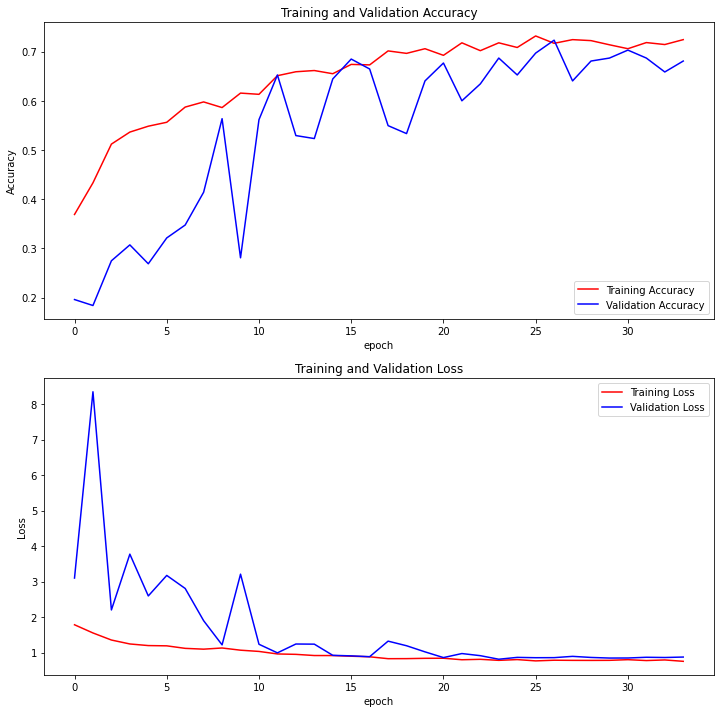

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='red')
plt.plot(val_loss, label='Validation Loss', color='blue')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')
plt.show()


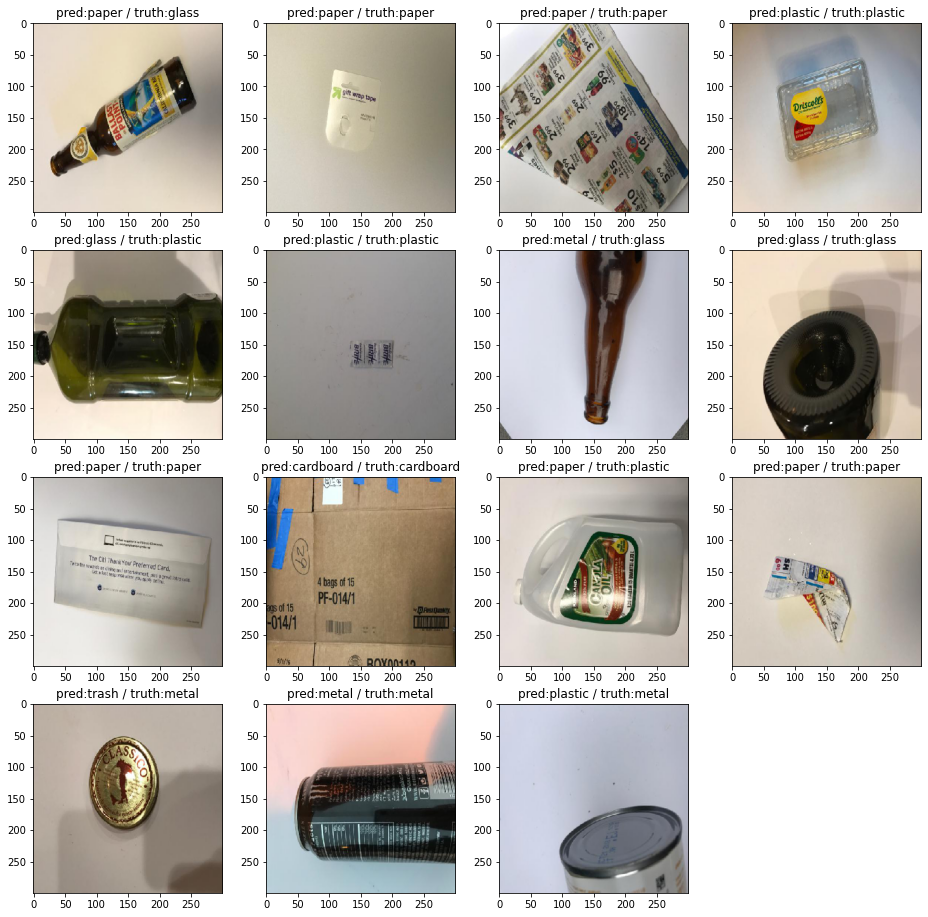

In [43]:
test_x, test_y = validation_generator.__getitem__(1) #I think gets index 1 from dataframe (need to make sure)

labels = (train_generator.class_indices) #the mapping from class names to class indices
labels = dict((v,k) for k,v in labels.items()) #creates a dictionary by iterating through the indices

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [44]:

!pip install streamlit
!pip install pyngrok===4.1.1
from pyngrok import ngrok


In [45]:
%%writefile trash-classification-app.py
import streamlit as st
import base64
import sklearn
import numpy as np
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
scal=MinMaxScaler()
import pickle as pkl
pkl.dump(model,open("final_model.p","wb"))
model.save("final_model.p")
#Load the saved model
model=pkl.load(open("final_model.p","rb"))
from PIL import Image

# Load your classification model


# Create a function that uses the model to predict the classification
# of an image of garbage
def predict(image):
    prediction = model.predict(image)
    return prediction

# Create the main function of your Streamlit app
def main():
    st.title("Garbage Classification App")
    st.markdown("Upload an image of garbage to classify it")

    # Allow the user to upload an image
    image = st.file_uploader("Choose an image", type=["jpg", "png"])

    # Check if the user has uploaded an image
    if image is not None:
        # Convert the uploaded image to a PIL image
        image = Image.open(image)

        # Use the classification model to predict the classification
        # of the image
        prediction = predict(image)

        # Display the prediction to the user
        st.image(image)
        st.markdown(f"This is a {prediction}")

# Run the main function
if __name__ == "__main__":
    main()




Overwriting trash-classification-app.py


In [46]:

!nohup streamlit run trash-classification-app.py &
url = ngrok.connect(port='8501')


OSError: Background processes not supported.